In [69]:
import pandas as pd
import numpy as np 
import tqdm
import matplotlib.pyplot as plt
import scipy

from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from functools import partial
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data

# Setting output dictionary
output_dir = '/content/drive/MyDrive/Colab Notebooks/spatial_proj/'

df = pd.read_csv(output_dir + 'master_data.csv').iloc[:,0:-1]
df.rename(columns = {'newcases_tplus1' : 'newcases_tplus2', 'newcases_tplus2' : 'newcases_tplus3', 'newcases_tplus4' : 'newcases_tplus5', 'newcases' : 'newcases_tplus1'},inplace=True)

## Utilities

In [111]:
def predict_quantiles(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
  estimator.fit(X_train,y_train)
  y_pred = estimator.predict(X_test)
  print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )

  return y_pred

def choosehorizon(dataframe,pred : int,lags):
    """
    This function takes in the master dataframe and spits out the lags that you want to include,
    and then sorts the data so that it's easier to look at.
    """
    if pred not in [1,2,4]:
        print(f"Sorry, but the only available prediction horizons are 1,2 and 4 weeks ahead!")
        return None
    elif (max(lags) > 4) or (min(lags) < 1):
        if len(lags) == 0:
            print("You have specified zero lags! Nonsense!")
        else: print("Your lags are out of bounds...")
    
    lagcols = [col for col in list(dataframe.columns) if 'tminus' in col]
    
    lagschosen = []
    for lag in lags:
        lagschosen += [col for col in lagcols if str(lag) in col]
        
    lagschosen.sort()
    sociocols = [col for col in list(dataframe.columns) if '2019' in col]
    indices = ['Y-W','province']
    y = f"newcases_tplus{pred}"
    
    allcols = indices + [y] + lagschosen + sociocols
    
    # Given lags, take out data that contains NaNs due to data unavailability
    # First week when we have data is 2020-10, so add up weeks according to lags..
    max_lag = max(lags)
    # first_week = f"2020-{10+max_lag}"
    first_week = '2021-01'
    last_week = '2021-52'
    
    # Given that we are predicting into the future, we need to take off as many weeks as we
    # are predicting into the future for, because otherwise we have NaNs..
    last_week = f"2022-{10-pred}"
    
    # We also need to take care of the fact that we only have Google Mobility data up to 2021-52
    last_week_google = f"2021-52"
    
    last_effective_week = [last_week,last_week_google]
    last_effective_week.sort()
    dataframe = dataframe[(dataframe['Y-W'] >= first_week) & (dataframe['Y-W'] <= last_effective_week[0])]
    dataframe.reset_index(drop=True,inplace=True)
    return dataframe[allcols],y

## XGBQuantile class

In [13]:
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])**2/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])**2/(np.sum(hessian[i:])+l)-np.sum(gradient)**2/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

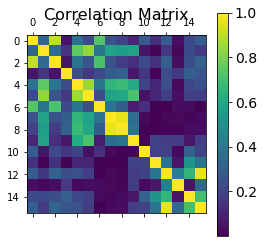

In [239]:
data, depvarname = choosehorizon(df,1,[1])

plt.matshow(np.abs(data.corr()))
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Train/test, step parameters

In [15]:
training_size = 30 # week
testing_size = 1 # week
num_counties = len(data.province.value_counts().index)
time_steps = 22

## Prediction Intervals

The following function `get_bound_cv` allows to compute a quantile regression with use of tweaked XGBoost algorithm.

In [177]:
def get_bound_cv(data: pd.DataFrame, depvarname: str, alpha: float, 
                 param_distributions: dict, training_size: int, 
                 testing_size: int, num_counties: int, time_steps: int, 
                 n_iter: int):
    '''
    Compute Pridiction Intervals with using XGBoost with tweaked gradient and
    Hessian.
    
    Parameters:
        data:                 Data Frame
        depvarname:           Name of the dependent variable
        alpha:                Quantile to obtain.
        param_distributions:  Defines parameter distributions used by Random
                              Search routine.
        training_size:        Initial window size for the Exanding Window CV.
        testing_size:         For prediction intervals, we consider only one 
                              week ahead prediction problem. So the testing 
                              size is 1.
        num_counties:         Total number of counties in the country, in our
                              case is 18.
        time_steps:           Number of weeks that we make predictions for,
                              in our case is 22.
        n_iter:               Number of iterations for Randomized Search algorithm.

    '''
    # We pick the whole dataset to perform Randomized CV search for parameters to 
    # build Prediction Intervals. The parameters go into XGBoost-Quantile algorithm.

    X = data.iloc[:, 3:]
    X = np.matrix(X)
    y = data.loc[:, depvarname]

    percentile_model = XGBQuantile(seed=42, quant_alpha = alpha)

    # Since we have temporal structure as well, cross-validation should be done in
    # specific way. In this case we pick 

    cv = [(slice(0, 
                 (training_size + i)*num_counties), 
           slice((training_size + i)*num_counties, 
                 (training_size + i + testing_size) * num_counties)) 
          for i in range(time_steps)]

    # The pipeline combines Standard Scaler for X and the XGBQuantile model.
    pipeline = make_pipeline(StandardScaler(), percentile_model)

    # Specify the Randomized Search (Cross-Validation) routine to get parameters. 
    rs_cv  = RandomizedSearchCV(pipeline, 
                                param_distributions=param_distributions,
                                n_iter=200, cv=cv, verbose = 1)
    rs_cv.fit(X,y)
    # Get the best estimator, according to cross-validated mse.
    percentile_estimator = rs_cv.best_estimator_
    y_bound = []

    for train_idxs, test_idxs in cv:
        X_train = np.matrix(data.iloc[train_idxs, 3:])
        X_test = np.matrix(data.iloc[test_idxs, 3:])
        y_train = np.array(data.iloc[train_idxs, data.columns == depvarname])
        y_test = np.array(data.iloc[test_idxs, data.columns == depvarname])
        y_week_bound = predict_quantiles(X_train,y_train,X_test,y_test,
                                         estimator=percentile_estimator,
                                         alpha=alpha,model_name="Quantile XGB")
        y_bound += [np.exp(y_week_bound) - 1]

    y_bound = np.array(y_bound).sum(axis = 1)
    return(y_bound)

In [ ]:
y = data.loc[:, depvarname]

In [167]:
param_distributions = {'xgbquantile__quant_delta':scipy.stats.uniform(0.01,10.0),
                       'xgbquantile__quant_var':scipy.stats.uniform(1.0,10.0),
                       'xgbquantile__quant_thres':scipy.stats.uniform(0.01,10.0)}

In [ ]:
y_lower = get_bound_cv(data=data, depvarname=depvarname, alpha=0.05,
                       param_distributions=param_distributions,
                       training_size=training_size, testing_size=testing_size,
                       num_counties=num_counties, time_steps=time_steps,
                       n_iter=200)
y_upper = get_bound_cv(data=data, depvarname=depvarname, alpha=0.95,
                       param_distributions=param_distributions,
                       training_size=training_size, testing_size=testing_size,
                       num_counties=num_counties, time_steps=time_steps,
                       n_iter=200)
real_cases = (np.exp(np.array(y).reshape(52, 18)[30:,]) - 1).sum(axis=1)

In [203]:
# Retrieve predictions from the pre-computed table

predictions = pd.read_csv(output_dir + 'onelag_predict_cases.csv').iloc[:, 2:]
columns_prediction = [colname for colname in predictions.columns 
                      if '_predicted' in colname]
predicted_cases = np.array(predictions[columns_prediction].sum(axis=0))

### Plot Intervals

The next routine provides a plot with the computed prediction intervals.

In [235]:
def plot_intervals(x_range, real_cases,predicted_cases,y_upper,y_lower):
  x_axis = x_range

  fig, ax = plt.subplots()

  ax.plot(x_axis, real_cases, color= 'red', label='Real Cases')
  ax.plot(x_axis, predicted_cases, color= 'green', label='Predicted Cases')
  ax.plot(x_axis, y_upper, 'k-')
  ax.plot(x_axis, y_lower, 'k-')
  ax.fill_between(x_axis,y_lower, y_upper, alpha=.5, fc='b', ec='None', 
                  label='90% prediction interval')
  ax.legend(loc = 'upper left')

  plt.xlabel("Week")
  plt.ylabel("Number of Cases")
  plt.title("Predicted and Real Cases over all of Finland (1 week ahead)")
  plt.show()

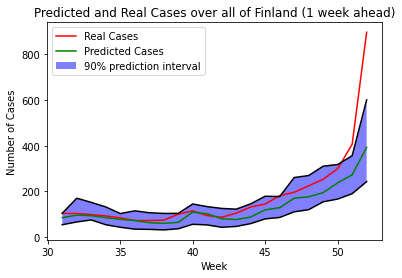

In [238]:
x_range = np.arange(31, 53, 1)
plot_intervals(x_range, real_cases, predicted_cases, y_upper, y_lower)